# Logistic Regression

In [2]:
import piplite
await piplite.install(['pandas'])
await piplite.install(['matplotlib'])
await piplite.install(['numpy'])
await piplite.install(['scikit-learn'])
await piplite.install(['scipy'])


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pylab as pl
import scipy.optimize as opt
from sklearn import preprocessing

In [7]:
from pyodide.http import pyfetch

async def download(url,filename):
    response = await pyfetch(url)
    if response.status == 200:
        with open(filename, 'wb') as f:
            f.write(await response.bytes())

## The Dataset

a telecommunications dataset for predicting customer churn. This is a historical customer dataset where each row represents one customer. The data is relatively easy to understand, and you may uncover insights you can use immediately. Typically it is less expensive to keep customers than acquire new ones, so the focus of this analysis is to predict the customers who will stay with the company.
This data set provides information to help you predict what behavior will help you to retain customers. You can analyze all relevant customer data and develop focused customer retention programs.

In [9]:
# load the data
path = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/ChurnData.csv"

In [10]:
await download(path, 'ChurnData.csv')
path = 'ChurnData.csv'

In [11]:
churn_df = pd.read_csv(path)
churn_df.head()

,tenure,age,address,income,ed,employ,equip,callcard,wireless,longmon,...,pager,internet,callwait,confer,ebill,loglong,logtoll,lninc,custcat,churn
0,11.0,33.0,7.0,136.0,5.0,5.0,0.0,1.0,1.0,4.40,...,1.0,0.0,1.0,1.0,0.0,1.482,3.033,4.913,4.0,1.0
1,33.0,33.0,12.0,33.0,2.0,0.0,0.0,0.0,0.0,9.45,...,0.0,0.0,0.0,0.0,0.0,2.246,3.240,3.497,1.0,1.0
2,23.0,30.0,9.0,30.0,1.0,2.0,0.0,0.0,0.0,6.30,...,0.0,0.0,0.0,1.0,0.0,1.841,3.240,3.401,3.0,0.0
3,38.0,35.0,5.0,76.0,2.0,10.0,1.0,1.0,1.0,6.05,...,1.0,1.0,1.0,1.0,1.0,1.800,3.807,4.331,4.0,0.0
4,7.0,35.0,14.0,80.0,2.0,15.0,0.0,1.0,0.0,7.10,...,0.0,0.0,1.0,1.0,0.0,1.960,3.091,4.382,3.0,0.0


### Data preprocessing and selection

In [12]:
chrun_df = churn_df[['tenure', 'age', 'address', 'income', 'ed', 'employ', 'equip',   'callcard', 'wireless','churn']]
churn_df['churn'] = churn_df['churn'].astype('int')
churn_df.head()

,tenure,age,address,income,ed,employ,equip,callcard,wireless,longmon,...,pager,internet,callwait,confer,ebill,loglong,logtoll,lninc,custcat,churn
0,11.0,33.0,7.0,136.0,5.0,5.0,0.0,1.0,1.0,4.40,...,1.0,0.0,1.0,1.0,0.0,1.482,3.033,4.913,4.0,1
1,33.0,33.0,12.0,33.0,2.0,0.0,0.0,0.0,0.0,9.45,...,0.0,0.0,0.0,0.0,0.0,2.246,3.240,3.497,1.0,1
2,23.0,30.0,9.0,30.0,1.0,2.0,0.0,0.0,0.0,6.30,...,0.0,0.0,0.0,1.0,0.0,1.841,3.240,3.401,3.0,0
3,38.0,35.0,5.0,76.0,2.0,10.0,1.0,1.0,1.0,6.05,...,1.0,1.0,1.0,1.0,1.0,1.800,3.807,4.331,4.0,0
4,7.0,35.0,14.0,80.0,2.0,15.0,0.0,1.0,0.0,7.10,...,0.0,0.0,1.0,1.0,0.0,1.960,3.091,4.382,3.0,0


In [15]:
churn_df.columns

Index(['tenure', 'age', 'address', 'income', 'ed', 'employ', 'equip',
       'callcard', 'wireless', 'longmon', 'tollmon', 'equipmon', 'cardmon',
       'wiremon', 'longten', 'tollten', 'cardten', 'voice', 'pager',
       'internet', 'callwait', 'confer', 'ebill', 'loglong', 'logtoll',
       'lninc', 'custcat', 'churn'],
      dtype='object')

In [16]:
chrun_df.shape

(200, 10)

In [22]:
churn_df.dtypes

tenure      float64
age         float64
address     float64
income      float64
ed          float64
employ      float64
equip       float64
callcard    float64
wireless    float64
longmon     float64
tollmon     float64
equipmon    float64
cardmon     float64
wiremon     float64
longten     float64
tollten     float64
cardten     float64
voice       float64
pager       float64
internet    float64
callwait    float64
confer      float64
ebill       float64
loglong     float64
logtoll     float64
lninc       float64
custcat     float64
churn         int32
dtype: object

In [23]:
# defining x and y for your dataset

X = np.array(chrun_df[['tenure', 'age', 'address', 'income', 'ed', 'employ', 'equip']])
X[0:5]

array([[ 11.,  33.,   7., 136.,   5.,   5.,   0.],
       [ 33.,  33.,  12.,  33.,   2.,   0.,   0.],
       [ 23.,  30.,   9.,  30.,   1.,   2.,   0.],
       [ 38.,  35.,   5.,  76.,   2.,  10.,   1.],
       [  7.,  35.,  14.,  80.,   2.,  15.,   0.]])

In [24]:
y = np.array(chrun_df['churn'])
y[0:5]

array([1., 1., 0., 0., 0.])

In [26]:
# normalize the dataset

from sklearn import preprocessing
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[-1.13518441, -0.62595491, -0.4588971 ,  0.4751423 ,  1.6961288 ,
        -0.58477841, -0.85972695],
       [-0.11604313, -0.62595491,  0.03454064, -0.32886061, -0.6433592 ,
        -1.14437497, -0.85972695],
       [-0.57928917, -0.85594447, -0.261522  , -0.35227817, -1.42318853,
        -0.92053635, -0.85972695],
       [ 0.11557989, -0.47262854, -0.65627219,  0.00679109, -0.6433592 ,
        -0.02518185,  1.16316   ],
       [-1.32048283, -0.47262854,  0.23191574,  0.03801451, -0.6433592 ,
         0.53441472, -0.85972695]])

In [ ]:
### Train/Test dataset

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split (X, y, test_size =.20, random_state=4)
print('X_train.shape=', X_train.shape, 'Y_train.shape', y_train.shape)
print('X_test.shape=', X_test.shape, 'Y_test.shape', y_test.shape)

X_train.shape= (160, 7) Y_train.shape (160,)
X_test.shape= (40, 7) Y_test.shape (40,)


## Modeling logistic regression with sklearn

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train, y_train)
LR

LogisticRegression(C=0.01, solver='liblinear')

In [31]:
# now predict using the test set 

yhat = LR.predict(X_test)
yhat

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0.])

In [32]:
yhat_prob = LR.predict_proba(X_test)
yhat_prob

array([[0.54132919, 0.45867081],
       [0.60593357, 0.39406643],
       [0.56277713, 0.43722287],
       [0.63432489, 0.36567511],
       [0.56431839, 0.43568161],
       [0.55386646, 0.44613354],
       [0.52237207, 0.47762793],
       [0.60514349, 0.39485651],
       [0.41069572, 0.58930428],
       [0.6333873 , 0.3666127 ],
       [0.58068791, 0.41931209],
       [0.62768628, 0.37231372],
       [0.47559883, 0.52440117],
       [0.4267593 , 0.5732407 ],
       [0.66172417, 0.33827583],
       [0.55092315, 0.44907685],
       [0.51749946, 0.48250054],
       [0.485743  , 0.514257  ],
       [0.49011451, 0.50988549],
       [0.52423349, 0.47576651],
       [0.61619519, 0.38380481],
       [0.52696302, 0.47303698],
       [0.63957168, 0.36042832],
       [0.52205164, 0.47794836],
       [0.50572852, 0.49427148],
       [0.70706202, 0.29293798],
       [0.55266286, 0.44733714],
       [0.52271594, 0.47728406],
       [0.51638863, 0.48361137],
       [0.71331391, 0.28668609],
       [0.

In [33]:
# Evaluation W/ jaccard index

from sklearn.metrics import jaccard_score
jaccard_score(y_test, yhat,pos_label=0)

0.7058823529411765

In [34]:
# Confusion Matrix is another way to look at the accuracy of the, 
# classifier is to look at confusino matrix

from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print(confusion_matrix(y_test, yhat, labels=[1,0]))


[[ 6  9]
 [ 1 24]]


Confusion matrix, without normalization
[[ 6  9]
 [ 1 24]]


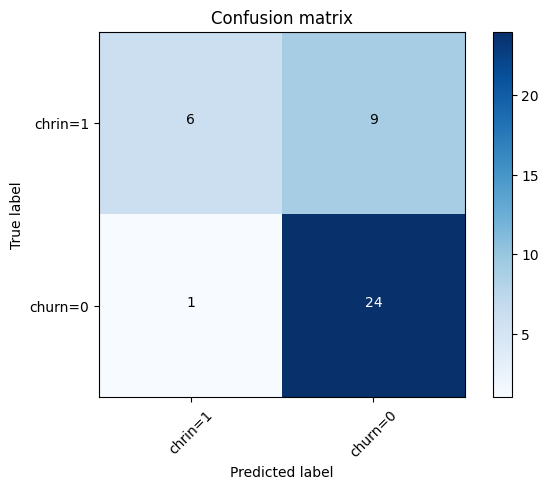

In [37]:
# compute confusinon Matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,0])
np.set_printoptions(precision=2)

# plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes =['chrin=1', 'churn=0'],normalize=False, title='Confusion matrix') 

Let's look at first row. The first row is for customers whose actual churn value in the test set is 1. As you can calculate, out of 40 customers, the churn value of 15 of them is 1. Out of these 15 cases, the classifier correctly predicted 6 of them as 1, and 9 of them as 0.

This means, for 6 customers, the actual churn value was 1 in test set and classifier also correctly predicted those as 1. However, while the actual label of 9 customers was 1, the classifier predicted those as 0, which is not very good. We can consider it as the error of the model for first row.

What about the customers with churn value 0? Lets look at the second row. It looks like there were 25 customers whom their churn value were 0.

The classifier correctly predicted 24 of them as 0, and one of them wrongly as 1. So, it has done a good job in predicting the customers with churn value 0. A good thing about the confusion matrix is that it shows the model’s ability to correctly predict or separate the classes. In a specific case of the binary classifier, such as this example, we can interpret these numbers as the count of true positives, false positives, true negatives, and false negatives.

In [39]:
print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

         0.0       0.73      0.96      0.83        25
         1.0       0.86      0.40      0.55        15

    accuracy                           0.75        40
   macro avg       0.79      0.68      0.69        40
weighted avg       0.78      0.75      0.72        40



* Precision is a measure of the accuracy provided that a class label has been predicted. It is defined by: precision = TP / (TP + FP)

* Recall is the true positive rate. It is defined as: Recall =  TP / (TP + FN)

So, we can calculate the precision and recall of each class.

* F1 score: Now we are in the position to calculate the F1 scores for each label based on the precision and recall of that label.

The F1 score is the harmonic average of the precision and recall, where an F1 score reaches its best value at 1 (perfect precision and recall) and worst at 0. It is a good way to show that a classifer has a good value for both recall and precision.

### log loss
Now, let's try log loss for evaluation. In logistic regression, the output can be the probability of customer churn is yes (or equals to 1). This probability is a value between 0 and 1. Log loss( Logarithmic loss) measures the performance of a classifier where the predicted output is a probability value between 0 and 1.

In [41]:
from sklearn.metrics import log_loss
log_loss(y_test, yhat_prob)

0.6017092478101185

* Try to build Logistic Regression model again for the same dataset, but this time, use different __solver__ and __regularization__ values? What is new __logLoss__ value?

In [44]:
LR2 = LogisticRegression(C=0.01, solver='sag').fit(X_train, y_train)
yhat2_prob = LR2.predict_proba(X_test)
print('Logloss equals : %.2f' % log_loss(y_test, yhat_prob))

Logloss equals : 0.60
